In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col, size, length, when, log1p, expm1, lower, count, lit
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
    .appName("Regression Evaluation") \
    .config("spark.driver.memory", "8g") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

DATA_PATH = "../../data/regression_price"

In [2]:
print("Loading and preparing data...")
df = spark.read.parquet(DATA_PATH)

has_array_features = [f.dataType for f in df.schema.fields if f.name == "features"]
if str(has_array_features[0]).startswith("ArrayType"):
    df = df.withColumn("features_count", size(col("features")))
else:
    if "features_count" not in df.columns and "features" in df.columns:
         df = df.withColumn("features_count", length(col("features")))

required_cols = ["rating_number", "average_rating", "main_category", "price"]
df_clean = df.dropna(subset=required_cols)

store_counts = df_clean.groupBy("store").agg(count("*").alias("store_freq"))
df_improved = df_clean.join(store_counts, on="store", how="left")
df_improved = df_improved.na.fill(0, subset=["store_freq", "features_count"])

if "title" in df_improved.columns:
    df_improved = df_improved.withColumn("title_len", length(col("title")))
    df_improved = df_improved.withColumn("is_premium", when(lower(col("title")).rlike("premium|pro|deluxe"), 1).otherwise(0))
    df_improved = df_improved.withColumn("is_bundle", when(lower(col("title")).rlike("bundle|set|pack"), 1).otherwise(0))

df_improved = df_improved.withColumn("log_rating_number", log1p(col("rating_number")))
df_improved = df_improved.withColumn("log_store_freq", log1p(col("store_freq")))

df_log = df_improved.withColumn("label", log1p(col("price")))

_, test_data = df_log.randomSplit([0.8, 0.2], seed=42)

test_data.cache()
print(f"Test data ready: {test_data.count()} rows")

Loading and preparing data...
Test data ready: 128776 rows


In [3]:
def evaluate_model(model_path, model_name):
    print(f"\n--- Evaluating: {model_name} ---")
    print(f"Loading from: {model_path}")
    
    try:
        model = PipelineModel.load(model_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    predictions = model.transform(test_data)
    
    predictions = predictions.withColumn("prediction_price", expm1(col("prediction")))
    
    predictions = predictions.withColumn(
        "prediction_price", 
        when(col("prediction_price") < 0, 0.01).otherwise(col("prediction_price"))
    )

    r2_eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
    rmse_eval = RegressionEvaluator(labelCol="price", predictionCol="prediction_price", metricName="rmse")
    mae_eval = RegressionEvaluator(labelCol="price", predictionCol="prediction_price", metricName="mae")

    r2 = r2_eval.evaluate(predictions)
    rmse = rmse_eval.evaluate(predictions)
    mae = mae_eval.evaluate(predictions)

    print(f"  R² (Log Scale): {r2:.4f}")
    print(f"  RMSE (Real $):  {rmse:.2f}")
    print(f"  MAE (Real $):   {mae:.2f}")

    sample_pdf = predictions.select("price", "prediction_price").sample(False, 0.05, seed=42).toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="price", y="prediction_price", data=sample_pdf, alpha=0.3)
    
    max_val = min(1000, max(sample_pdf["price"].max(), sample_pdf["prediction_price"].max())) # Обріжемо до 1000$ для наочності
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Prediction')
    
    plt.title(f"{model_name}: Actual vs Predicted Price")
    plt.xlabel("Actual Price ($)")
    plt.ylabel("Predicted Price ($)")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return predictions


--- Evaluating: Linear Regression ---
Loading from: ../../models/regression/lr_price_log_v1
  R² (Log Scale): -0.0399
  RMSE (Real $):  190.29
  MAE (Real $):   49.79


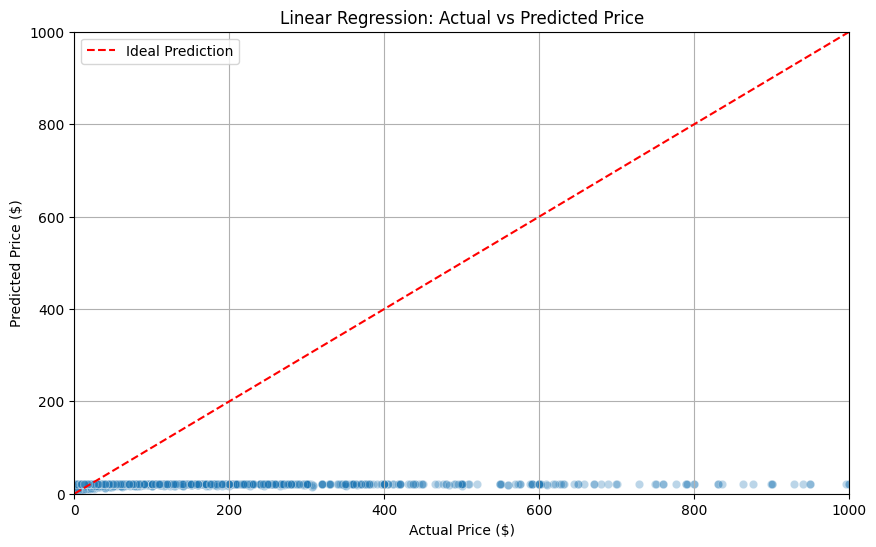

In [4]:
lr_path = "../../models/regression/lr_price_log_v1"

lr_predictions = evaluate_model(lr_path, "Linear Regression")